# Transformer Implementation

### Get the data

Download the data from [here](http://www.statmt.org/europarl/). We need to tokenize it and build an iterator for our embedding layer.

In [22]:
europarl_en = open('fr-en/europarl-v7.fr-en.en', encoding='utf-8').read().split('\n')
europarl_fr = open('fr-en/europarl-v7.fr-en.fr', encoding='utf-8').read().split('\n')

In [27]:
import spacy
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

en = spacy.load('en_core_web_sm')
fr = spacy.load('fr_core_news_sm')

def tokenize_en(sentence):
    return [tok.text for tok in en.tokenizer(sentence)]
def tokenize_fr(sentence):
    return [tok.text for tok in fr.tokenizer(sentence)]

EN_TEXT = Field(tokenize=tokenize_en)
FR_TEXT = Field(tokenize=tokenize_fr, init_token = "<sos>", eos_token = "<eos>")

In [28]:
import pandas as pd

raw_data = {'English' : [line for line in europarl_en], 'French': [line for line in europarl_fr]}
df = pd.DataFrame(raw_data, columns=["English", "French"])

# remove very long sentences and sentences where translations are not of roughly equal length
df['eng_len'] = df['English'].str.count(' ')
df['fr_len'] = df['French'].str.count(' ')
df = df.query('fr_len < 80 & eng_len < 80')
df = df.query('fr_len < eng_len * 1.5 & fr_len * 1.5 > eng_len')

In [29]:
from sklearn.model_selection import train_test_split

# create train and validation set 
train, val = train_test_split(df, test_size=0.1)
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)

In [33]:
# associate the text in the 'English' column with the EN_TEXT field, # and 'French' with FR_TEXT
data_fields = [('English', EN_TEXT), ('French', FR_TEXT)]
train,val = TabularDataset.splits(path='./', train='train.csv', validation='val.csv', format='csv', fields=data_fields)

In [34]:
FR_TEXT.build_vocab(train, val)
EN_TEXT.build_vocab(train, val)

In [38]:
train_iter = BucketIterator(train, batch_size=20, sort_key=lambda x: len(x.French), shuffle=True)

### Define the transformer implementation

A really nice resource can be found here - http://jalammar.github.io/illustrated-transformer/. The original paper is present [here](https://arxiv.org/abs/1706.03762).<br>

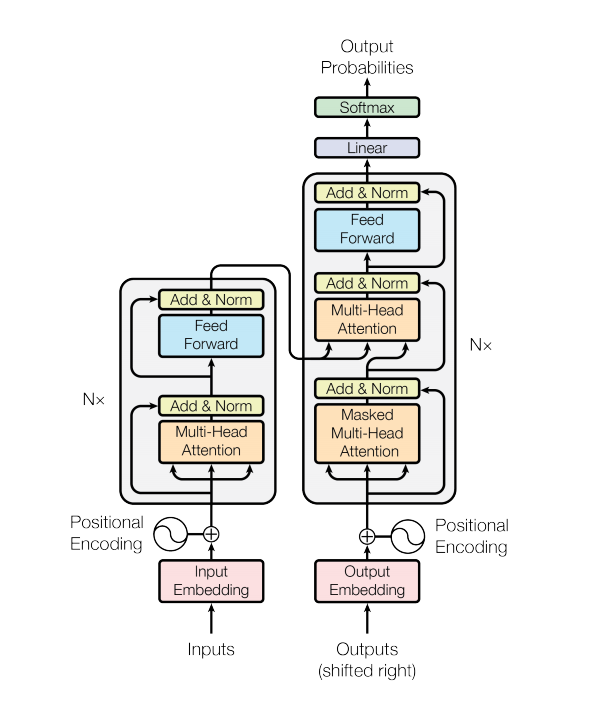

### Get all the required imports

In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

### Define a cloning function to get all the clones

In [51]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Define the embedding layer

In [52]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(Embedder, self).__init__()
        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embed(x)

### Define the positional encoding layer

In [105]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 200):
        super().__init__()
        self.d_model = d_model
        # create constant 'pe' matrix with values dependant on pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

### Define the masking and attention layers

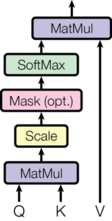

In [96]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    return torch.matmul(scores, v)

### Define the Multi-Head Attention

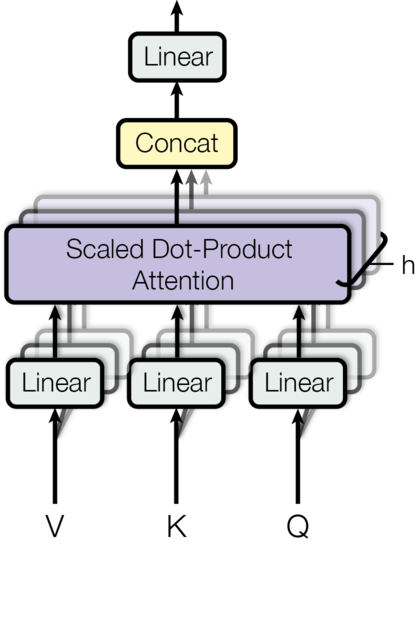

In [110]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super(MultiHeadedAttention, self).__init__()
        self.h = heads
        self.d_k = d_model // self.h
        self.d_model = d_model
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        
        #split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        # calculate attention
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
        
        return output

### Define the feed forward layer

In [56]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(p=dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

### Define normalisation

In [57]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True))/(x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

### Define a single encoder layer

In [58]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadedAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

### Define a single decoder layer

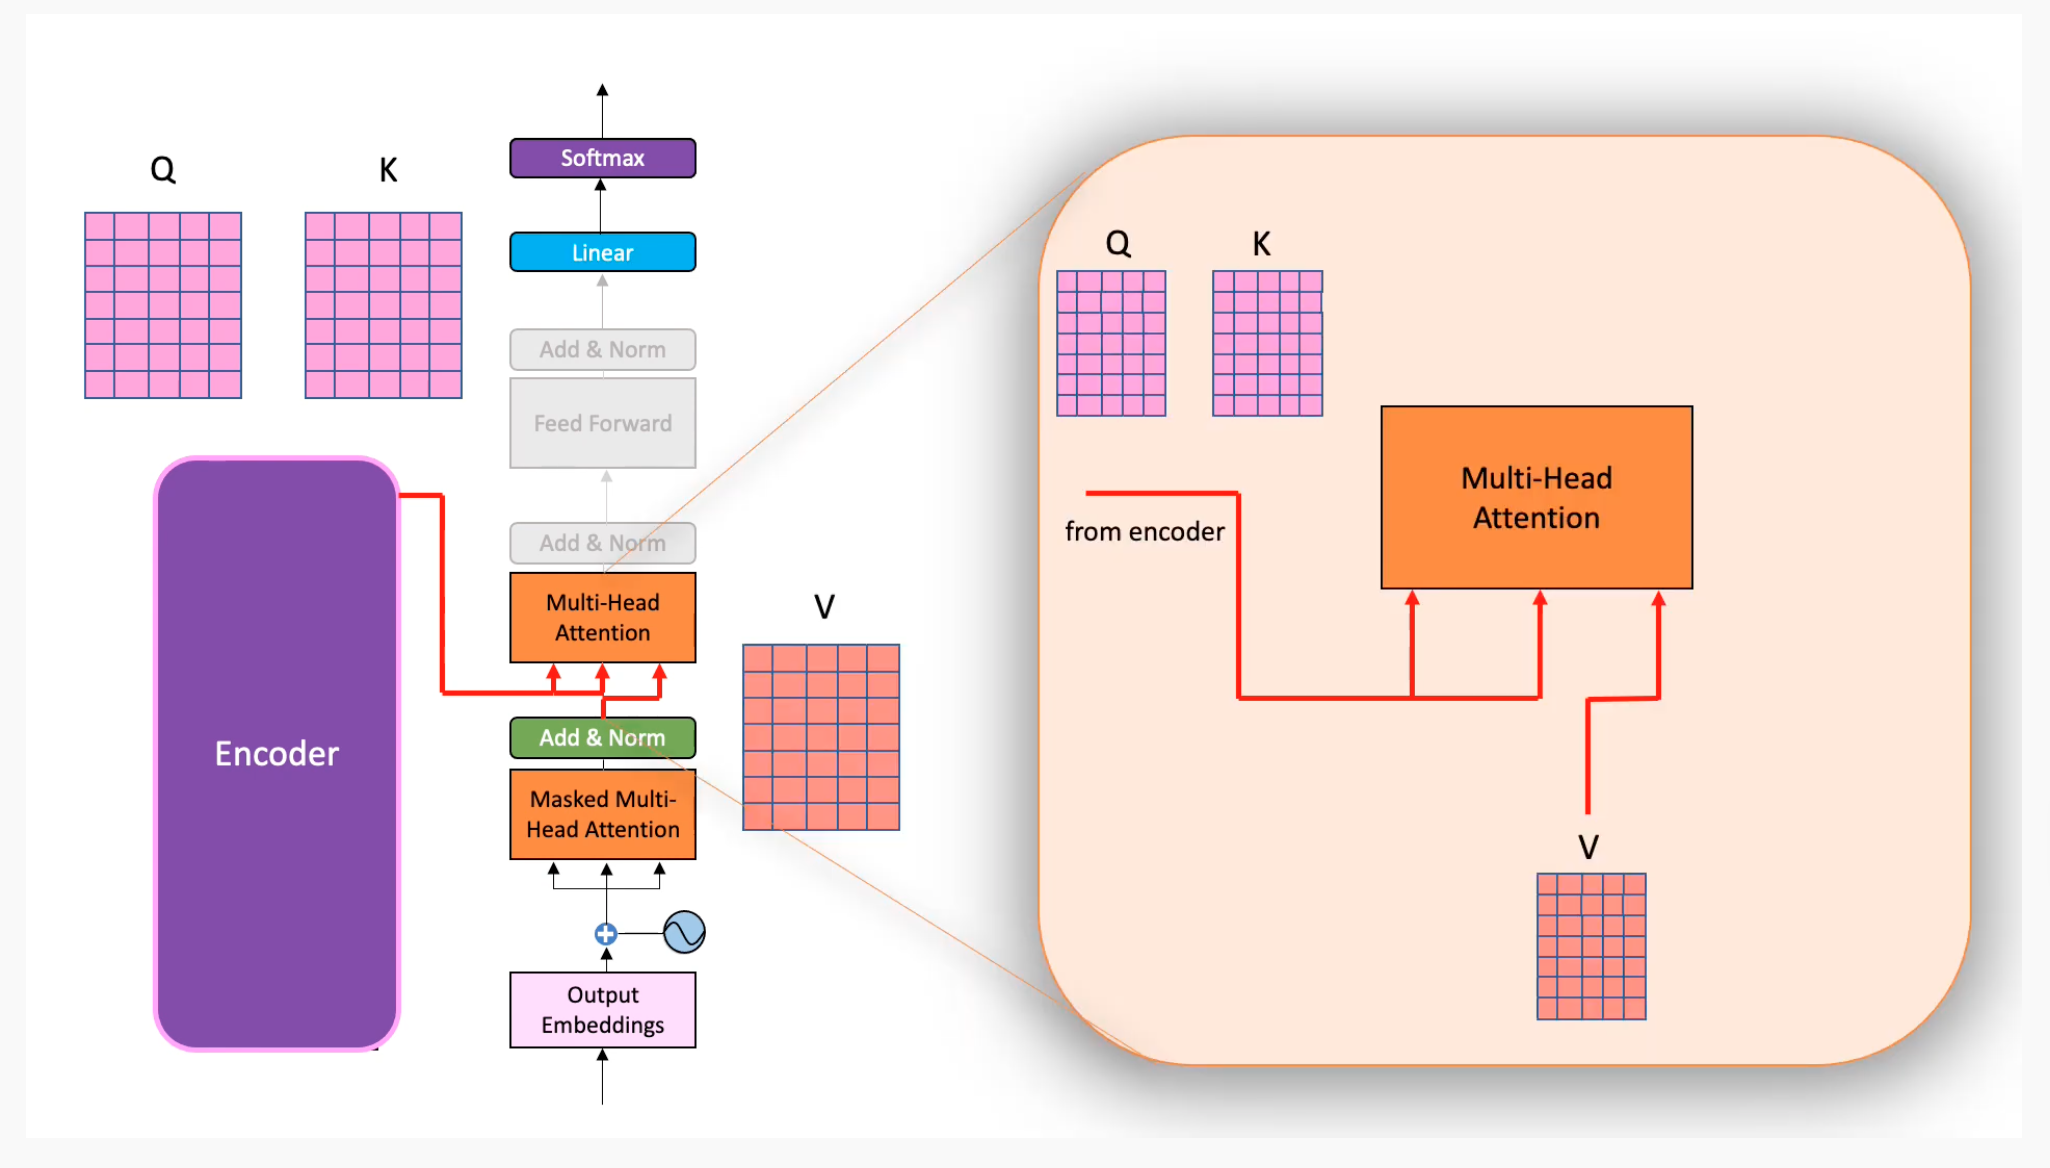

In [98]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadedAttention(heads, d_model)
        self.attn_2 = MultiHeadedAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        
    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2,x2,x2,trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2,e_outputs,e_outputs,src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

### Define the encoder and decoder

In [113]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
        
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

### Define the Transformer

In [107]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

### Define the masks 

For the source

In [79]:
batch = next(iter(train_iter))
input_seq = batch.English.transpose(0,1)
input_pad = EN_TEXT.vocab.stoi['<pad>']
# creates mask with 0s wherever there is padding in the input
input_msk = (input_seq != input_pad).unsqueeze(1)

For the target 

In [81]:
# create mask as before
target_seq = batch.French.transpose(0,1)
target_pad = FR_TEXT.vocab.stoi['<pad>']
target_msk = (target_seq != target_pad).unsqueeze(1)
size = target_seq.size(1) # get seq_len for matrix
nopeak_mask = np.triu(np.ones([1, size, size]),k=1).astype('uint8')
nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
target_msk = target_msk & nopeak_mask

### Training the model

In [114]:
d_model = 512
heads = 8
N = 6
src_vocab = len(EN_TEXT.vocab)
trg_vocab = len(FR_TEXT.vocab)
model = Transformer(src_vocab, trg_vocab, d_model, N, heads)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [103]:
print(model)

Transformer(
  (encoder): Encoder(
    (embed): Embedder(
      (embed): Embedding(109944, 512)
    )
    (pe): PositionalEncoder()
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (norm_2): Norm()
        (attn): MultiHeadedAttention(
          (q_linear): Linear(in_features=512, out_features=512, bias=True)
          (k_linear): Linear(in_features=512, out_features=512, bias=True)
          (v_linear): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff): FeedForward(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout_1): Dropout(p=0.1, inplace=False)
        (dropout_2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer

### Training the network

In [ ]:
epochs = 3

def nopeak_mask(size):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    return np_mask

def create_masks(src, trg):
    src_mask = (src != input_pad).unsqueeze(-2)
    if trg is not None:
        trg_mask = (trg != target_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask
    else:
        trg_mask = None
    return src_mask, trg_mask

def train_model(epochs, print_every=100):
    model.train()
    start = time.time()
    temp = start
    total_loss = 0
    for epoch in range(epochs):
        for i, batch in enumerate(train_iter):
            src = batch.English.transpose(0,1)
            trg = batch.French.transpose(0,1)
            # the French sentence we input has all words except the last, as it is using each word to predict the next
            trg_input = trg[:,:]
            # the words we are trying to predict
            targets = trg[:,:].contiguous().view(-1)
            # create function to make masks using mask code above
            src_mask, trg_mask = create_masks(src, trg_input)
            preds = model(src, trg_input, src_mask, trg_mask)
            optim.zero_grad()
            loss = F.cross_entropy(preds.view(-1, preds.size(-1)), targets, ignore_index=target_pad)
            loss.backward()
            optim.step()
            
            total_loss += loss
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, iter = %d, loss = %.3f, %ds per %d iters" % ((time.time() - start) // 60, epoch + 1, i + 1, loss_avg, time.time() - temp, print_every))
                total_loss = 0
                temp = time.time()
                
train_model(epochs)

time = 0m, epoch 1, iter = 1, loss = 11.155, 14s per 1 iters
time = 0m, epoch 1, iter = 2, loss = 11.085, 8s per 1 iters
time = 0m, epoch 1, iter = 3, loss = 11.039, 14s per 1 iters
time = 0m, epoch 1, iter = 4, loss = 10.976, 10s per 1 iters
time = 1m, epoch 1, iter = 5, loss = 10.878, 13s per 1 iters
time = 1m, epoch 1, iter = 6, loss = 10.808, 13s per 1 iters
time = 1m, epoch 1, iter = 7, loss = 10.727, 12s per 1 iters
time = 1m, epoch 1, iter = 8, loss = 10.665, 14s per 1 iters
time = 1m, epoch 1, iter = 9, loss = 10.624, 11s per 1 iters
time = 2m, epoch 1, iter = 10, loss = 10.552, 16s per 1 iters
time = 2m, epoch 1, iter = 11, loss = 10.464, 10s per 1 iters
time = 2m, epoch 1, iter = 12, loss = 10.423, 13s per 1 iters
time = 2m, epoch 1, iter = 13, loss = 10.320, 14s per 1 iters
time = 2m, epoch 1, iter = 14, loss = 10.272, 11s per 1 iters
time = 3m, epoch 1, iter = 15, loss = 10.217, 13s per 1 iters
time = 3m, epoch 1, iter = 16, loss = 10.133, 7s per 1 iters
time = 3m, epoch 1,